# Wildlife Recognition using Neural Networks

This is a notebook of a small project I have been doing for wildlife recognition on game camera images using machine learning. The go-to method for image classification is neural networks. In the last few years the accuracy of neural networks have increased to remarkable levels. For this project I have been using the fastai library.

Wildlife recognition using neural networks has been used for some time now. A common way to estimate the population of animals is to set up motion triggered cameras. Every time something moves in front of the sensor it will trigger the camera to snap an image. Obviously, this can provide a very large data set. The majority of the images are most often empty and if you are interested in just one particular rare species it can be a very demanding task to go through all of the images manually. Using a machine to classify the images makes it possible to monitor a much larger number of cameras and decreases the task of oberving every image. 
Personally, I am interested in this field to understand the populations of roe deer, foxes, pheasants, partridges and other animals on the land where I grew up and which I help to manage. 

The data I have used in this model is from the publication 'Machine learning to classify animal species in camera trap images: Applications in ecology' by Michael Tabak et al (2018). In the paper, the researchers also developed a model for animal detection and provide the images with labels for all the 3.7 million (!) images that they used to train there model. I am only working on a small subset of the data.The data set consists of images of animals snapped by the game cameras; cattle, elk, mountain lion, etc.

## Importing the data

I downloaded the images and put them into a specific folder. The labels are in a .csv file. This is one very common method to store labelled data for machine learning.  
One way to help the model learn on a relatively small data set (in this case just below 2000 images) is to use what is called data augmentation. Data augmentation is a very cool trick that artificially increase your data set by sightly changing the image. It is somewhat analogous to take a physical item and instead of having just one direction to oberserve it you can take it in your hand and look at it from different angles and distances. That gives a much better understanding of the object. The same is the case for the model

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
import numpy as np

In [3]:
tfms = get_transforms()
path='/home/nbuser/Wild'

In [5]:
np.random.seed(42)

In [6]:
data = ImageDataBunch.from_csv(path = path, folder ='images', csv_labels = 'image_labels.csv', ds_tfms = tfms, size = 224, bs=24)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList
y: CategoryList (1546 items)
[Category vehicle, Category human, Category vehicle, Category human, Category human]...
Path: /home/nbuser/Wild
x: ImageItemList (1546 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: /home/nbuser/Wild;

Valid: LabelList
y: CategoryList (386 items)
[Category human, Category cattle, Category cattle, Category human, Category empty]...
Path: /home/nbuser/Wild
x: ImageItemList (386 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: /home/nbuser/Wild;

Test: None

It is always a good idea to have some idea of what the data looks like. Here is a small batch of the images with labels that are in the data. As you can see there are many different animals as well as empty images, humans and also vehicles. You can also see that this is actually a very hard data set to classify! Also note how the images are warped and zoomed - that is the data augmentation taking place. The only disadvantage is that the zooming might completely crop some of the animals from the image, but it should not be too big a problem.

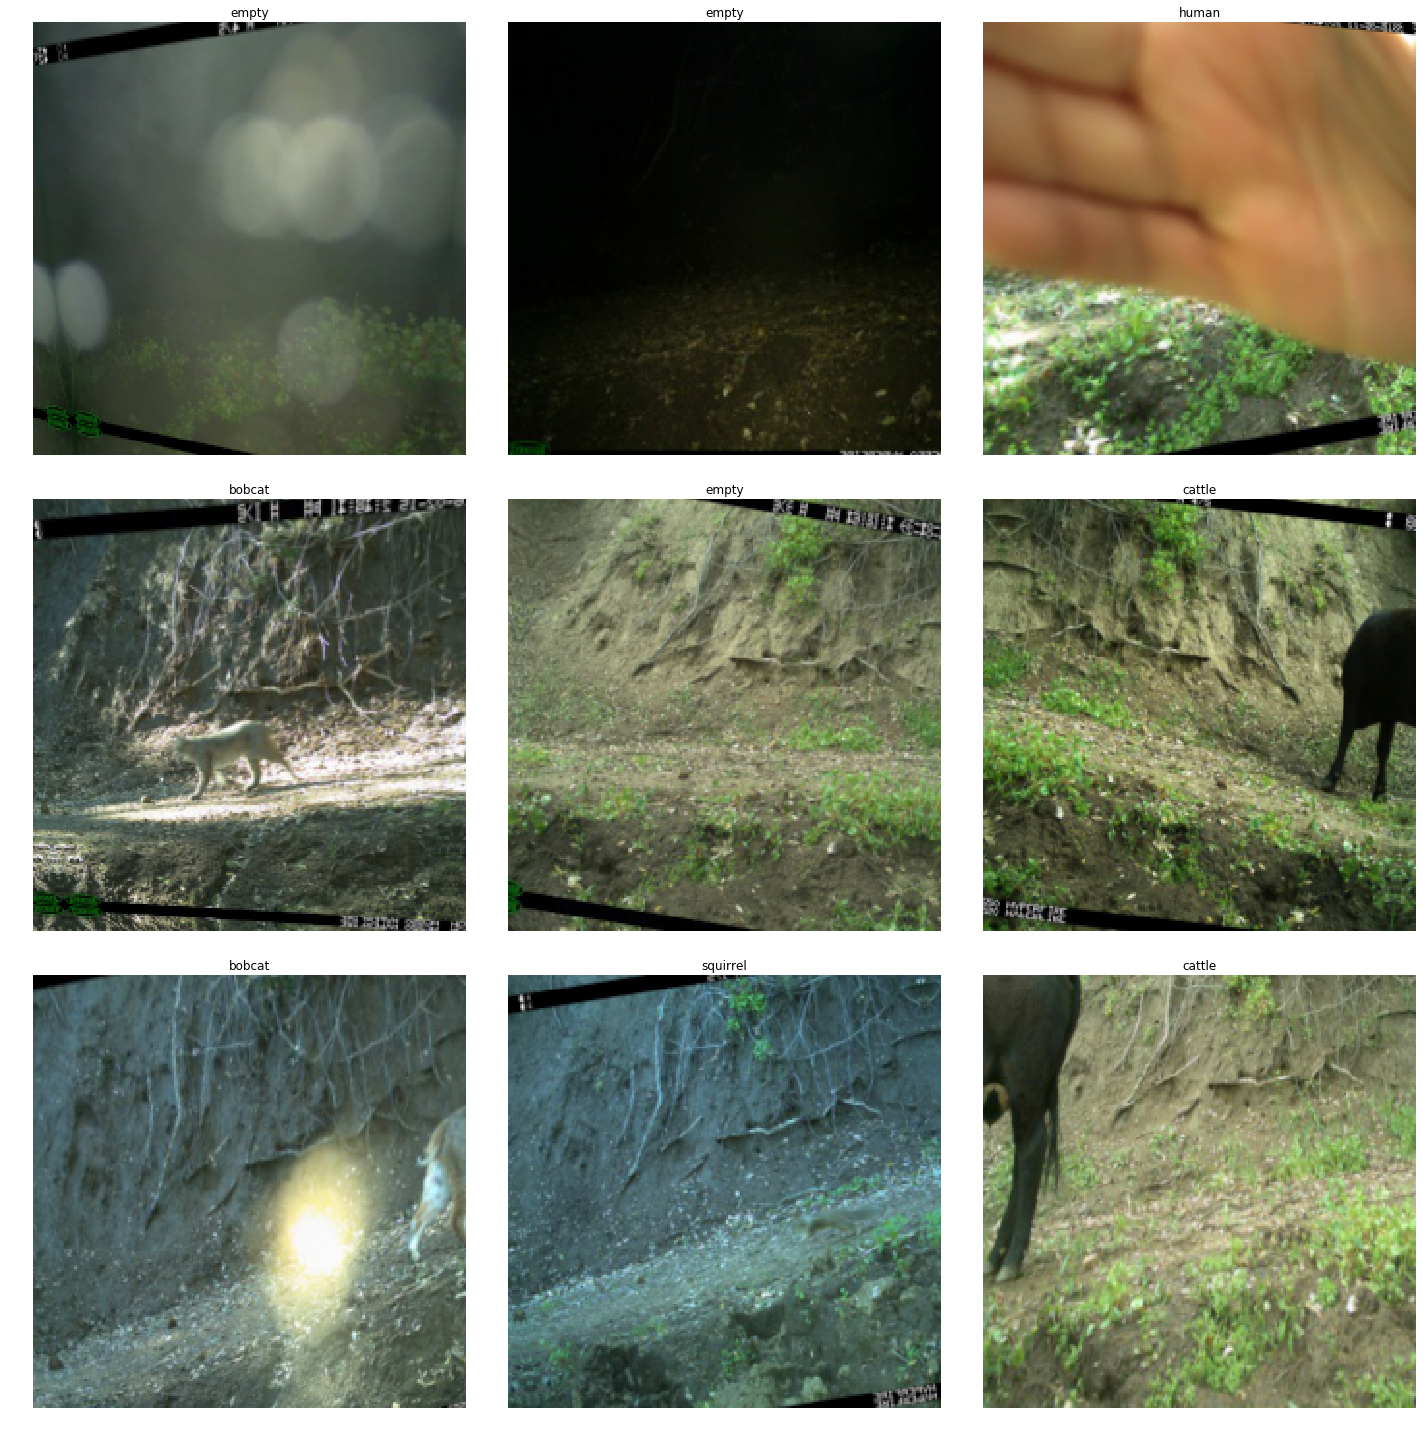

In [7]:
data.show_batch(rows = 3, figsize=(20,20))

In [22]:
print(data.classes); data.c

['bear', 'bobcat', 'canine', 'cattle', 'elk', 'empty', 'fox', 'human', 'pig', 'puma', 'skunk', 'squirrel', 'turkey', 'unknown', 'vehicle']


15

## Training on the data

Now it is time to train the model! The model I am using here is a convolutional neural network (CNN) of the type resnet50 (I tried a less complex model, resnet34, but got slightly better results with the more complex model. This is not always the case and there can be some drawbacks from using a larger model). One of the cool aspects of using the fastai library is that it is very easy to use pretrained models, which make it possible to get really good results using a quite small data set. The pretrained model that I am using is from the ImageNet competition, which is a more general classification model used to classify images into a 1000 catagories. Note that these are not the catagories that I am interested in, but I can slightly tweak the model to fit my images and get really good results. You can think of is as having a computer that already knows how to see and then telling it what elks and bobcats look like. 

In [26]:
learn = create_cnn(data, models.resnet50, metrics = error_rate)

In [27]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,1.183997,0.595172,0.202073
2,0.804702,0.493004,0.152850
3,0.578174,0.383601,0.129534
4,0.473184,0.352292,0.103627


In [28]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate
1,0.402917,0.332083,0.111399
2,0.406873,0.422072,0.134715
3,0.388906,0.306353,0.103627
4,0.401350,0.312468,0.113990
5,0.372017,0.276778,0.098446
6,0.321771,0.267270,0.077720
7,0.301037,0.263021,0.075130
8,0.299394,0.243466,0.072539
9,0.254355,0.238903,0.075130
10,0.241305,0.228320,0.072539


In [29]:
learn.save('resnet50-stage1')

In [30]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


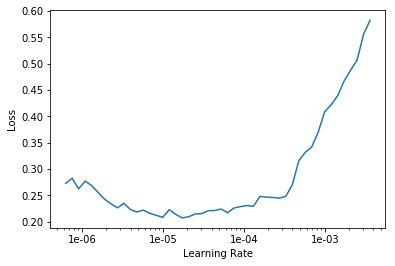

In [31]:
learn.recorder.plot()


In [32]:
learn.fit_one_cycle(4,max_lr=slice(1e-7,1e-6))

epoch,train_loss,valid_loss,error_rate
1,0.221438,0.219947,0.069948
2,0.232929,0.233581,0.075130
3,0.211486,0.226371,0.072539
4,0.241783,0.247333,0.072539


In [33]:
learn.save('resnet50')

Initially I trained the model for for 4 + 10 epochs, which is a fancy way of saying that I showed all of the training images to the computer 14 times for training. At that point the error rate didn't change any longer. You can see that the final error rate is 0.072, which means that the model can correctly classify 92.8 %. I decided to see if some fine tuning on the early layers of the model could maybe improve the accuracy slightly, but as you can see, there was not much of a change after that. 

Ok, so the model got dow no an error rate of about 0.07. This means that it can correctly classify the images in 93 % of the cases. Not too bad, but still not quite up there. The original article had a final accuracy of 97.6 %. You cannot directly compare the accuracy of the model from the article and the one I have produced here, since I am not using the same data set. Now let's see where the model had most of its problems. 

## Interpretation of the results

First, let's look at some of the images, that the model was the most wrong about.

In [34]:
interp = ClassificationInterpretation.from_learner(learn)

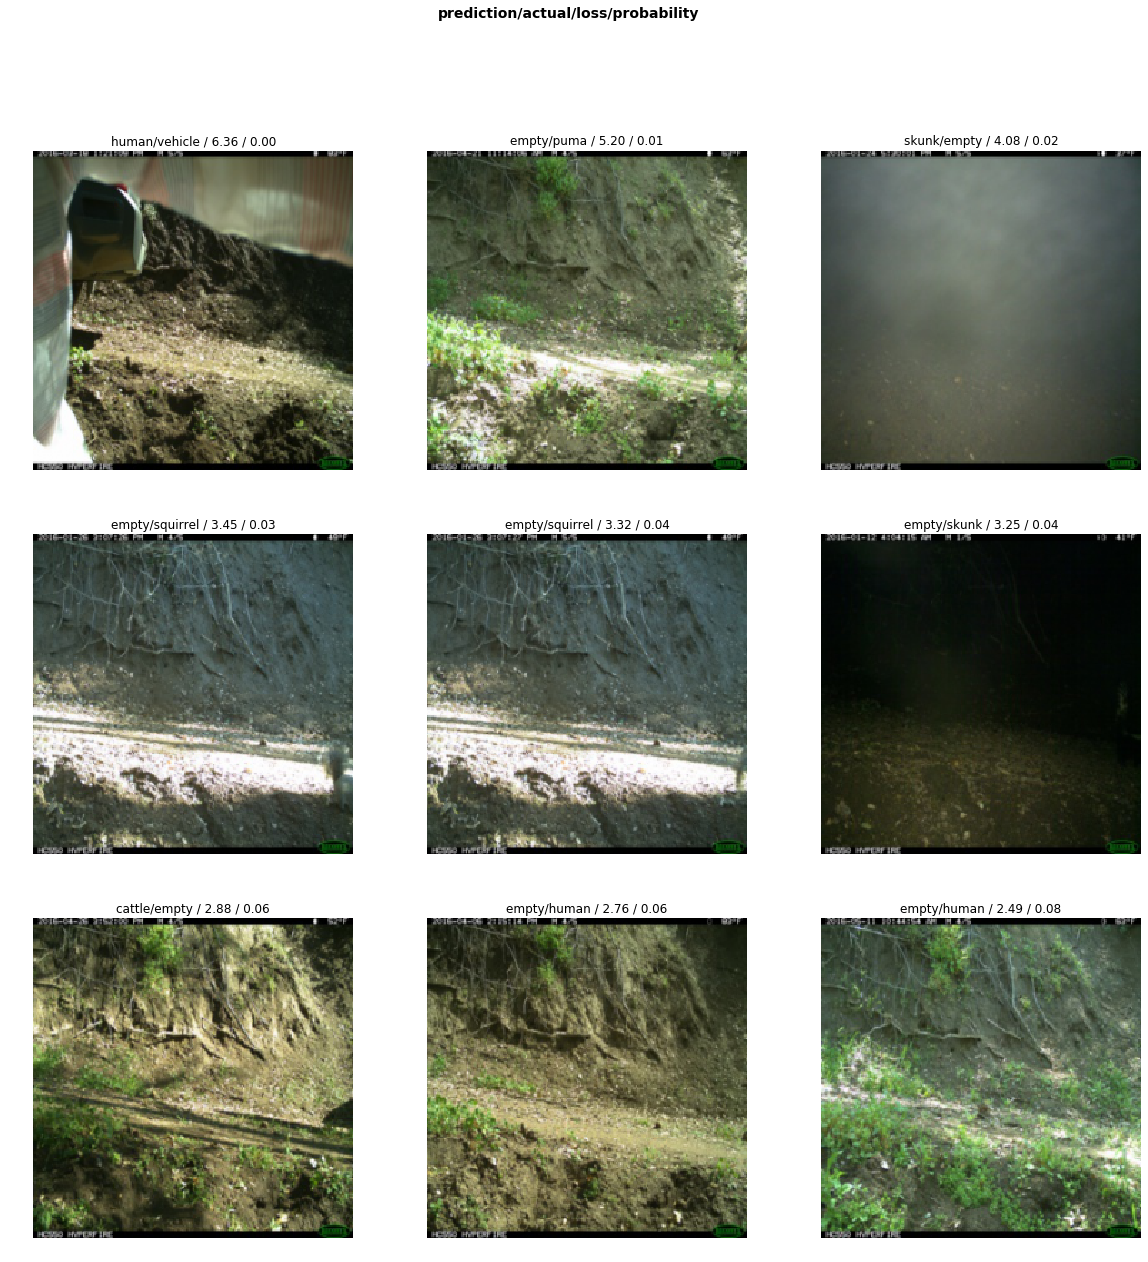

In [35]:
interp.plot_top_losses(9, figsize=(20,20))

The way to read the title above the images are first the models prediction and second the actual label assigned. To be completely honest I am having a really hard time classifying these images correctly as well. The first image clearly has a human and a vehicle, in the second I cannot see a mountain lion, and so on. In many of these cases I actually agree just as much with the model prediction as I do with the label assigned to the image manually.

Below is a so-called confusion matrix, where the number of predictions are compared to the actial classes. The off-diagonal elements are incorrectly classified.

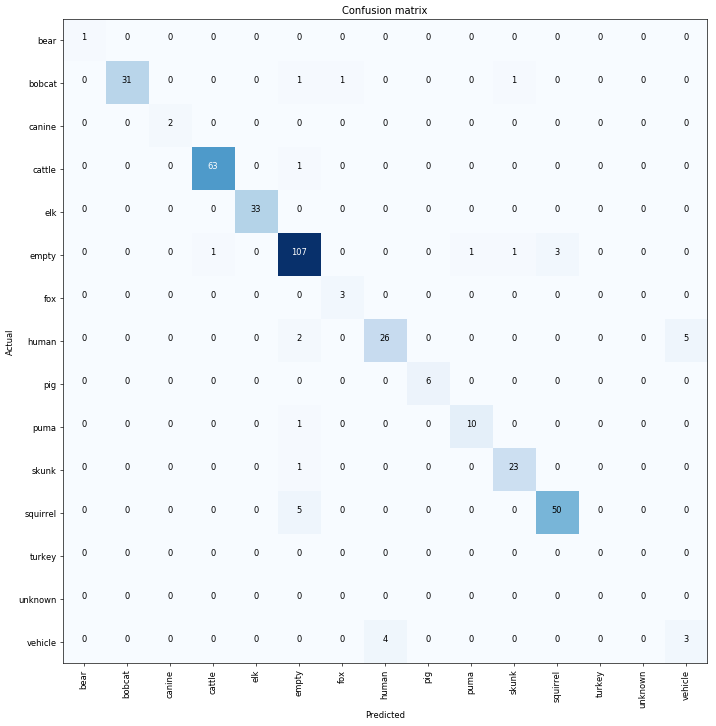

In [36]:
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

As you can see there are some problems with especially squirrel vs. empty and human vs. vehicle. You will also notice that some of the rows - turkey and unknown have all zeros. That is because there were no images with those labels in the validation set, so the model was never tested on those. That is a bit unfortunate, but is is simply because there were only very few of these images in the data set to begin with and when the split of the data into the training and validation set was made, none of the already few images of turkeys and unknown things were put into that group.

And that is the model. Now I just need some game camera images from Denmark to classify the local animals.